In [1]:
import numpy as np
import pandas as pd
import psutil

from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt

In [2]:
data_types_dict = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float16',
    'prior_question_had_explanation': 'boolean'
}


In [3]:
sample_size = (10**6)
file_path = 'C:/Users/dobrz/OneDrive/Рабочий стол/Kaggle/input/train.csv'
train = pd.read_csv(file_path, nrows=sample_size, index_col='row_id', usecols = data_types_dict.keys(),
                    dtype=data_types_dict)
train.head(100)

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,
0,0,115,5692,0,1,NaN,<NA>
1,56943,115,5716,0,1,36992.0,False
2,118363,115,128,0,1,55008.0,False
3,131167,115,7860,0,1,19008.0,False
4,137965,115,7922,0,1,11000.0,False
...,...,...,...,...,...,...,...
95,835457,2746,484,0,1,20000.0,True
96,0,5382,5000,0,1,NaN,<NA>
97,39828,5382,3944,0,0,24000.0,False


In [4]:
file_path = 'C:/Users/dobrz/OneDrive/Рабочий стол/Kaggle/input/lectures.csv'
lecture = pd.read_csv(file_path)
lecture.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [5]:
file_path = 'C:/Users/dobrz/OneDrive/Рабочий стол/Kaggle/input/questions.csv'
question = pd.read_csv(file_path)
question.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [6]:
print(f'train shape: {train.shape}')
print(f'lecture shape: {lecture.shape}')
print(f'question shape: {question.shape}')

train shape: (1000000, 7)
lecture shape: (418, 4)
question shape: (13523, 5)


In [7]:
train = train[train.answered_correctly != -1]

In [8]:
user_group = train.groupby('user_id')
user_answers = user_group.agg({'answered_correctly': ['mean', 'count'],'timestamp': ['mean']})
user_answers.columns = ['mean_user_accuracy', 'questions_answered', 'mean_user_time']
user_answers.head()

,mean_user_accuracy,questions_answered,mean_user_time
user_id,,,
115,0.695652,46,1.021248e+08
124,0.233333,30,3.678599e+05
2746,0.578947,19,3.689378e+05
5382,0.672000,125,3.663737e+08
8623,0.642202,109,3.448181e+08


In [9]:
content_group = train.groupby('content_id')
content_answer = content_group.agg({'answered_correctly': ['mean', 'count'],'timestamp': ['mean']})
content_answer.columns = ['mean_content_accuracy', 'question_asked', 'mean_content_time']
content_answer.head()

,mean_content_accuracy,question_asked,mean_content_time
content_id,,,
0,0.863014,73,6.075919e+09
1,0.927273,55,7.901304e+09
2,0.560811,444,4.760287e+09
3,0.798995,199,5.196043e+09
4,0.602606,307,4.643174e+09


In [10]:
questions = question.merge(content_answer, left_on = 'question_id', right_on = 'content_id', how = 'left')
bundle_dict = questions['bundle_id'].value_counts().to_dict()
questions['right_answers'] = questions['mean_content_accuracy'] * questions['question_asked']
questions['bundle_size'] =questions['bundle_id'].apply(lambda x: bundle_dict[x])
questions.head()

,question_id,bundle_id,correct_answer,part,tags,mean_content_accuracy,question_asked,mean_content_time,right_answers,bundle_size
0,0,0,0,1,51 131 162 38,0.863014,73.0,6.075919e+09,63.0,1
1,1,1,1,1,131 36 81,0.927273,55.0,7.901304e+09,51.0,1
2,2,2,0,1,131 101 162 92,0.560811,444.0,4.760287e+09,249.0,1
3,3,3,0,1,131 149 162 29,0.798995,199.0,5.196043e+09,159.0,1
4,4,4,3,1,131 5 162 38,0.602606,307.0,4.643174e+09,185.0,1


In [11]:
grouped_by_bundle = questions.groupby('bundle_id')
bundle_answers = grouped_by_bundle.agg({'right_answers': 'sum', 'question_asked': 'sum'})
bundle_answers.columns = ['bundle_rignt_answers', 'bundle_questions_asked']
bundle_answers['bundle_accuracy'] = bundle_answers['bundle_rignt_answers'] / bundle_answers['bundle_questions_asked']
bundle_answers.head()

,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy
bundle_id,,,
0,63.0,73.0,0.863014
1,51.0,55.0,0.927273
2,249.0,444.0,0.560811
3,159.0,199.0,0.798995
4,185.0,307.0,0.602606


In [12]:
grouped_by_part = questions.groupby('part')
part_answers = grouped_by_part.agg({'right_answers': 'sum', 'question_asked': 'sum'})
part_answers.columns = ['part_rignt_answers', 'part_questions_asked']
part_answers['part_accuracy'] = part_answers['part_rignt_answers'] / part_answers['part_questions_asked']
part_answers.head()

,part_rignt_answers,part_questions_asked,part_accuracy
part,,,
1,51075.0,69411.0,0.735834
2,134896.0,190731.0,0.707258
3,56873.0,82175.0,0.692096
4,47191.0,75997.0,0.620959
5,244493.0,403240.0,0.606321


In [13]:
new_train_df = train.merge(user_answers, how = 'left', on = 'user_id')\
                        .merge(questions, how = 'left', left_on = 'content_id', right_on = 'question_id')\
                        .merge(bundle_answers, how = 'left', on = 'bundle_id')\
                        .merge(part_answers, how = 'left', on = 'part')

In [14]:
new_train_df['prior_question_had_explanation'].fillna(False, inplace=True)
new_train_df['prior_question_had_explanation'] = new_train_df['prior_question_had_explanation'].apply(lambda x: 1 if x=='True' else 0)
new_train_df[new_train_df==np.inf]=np.nan
new_train_df.fillna(value = -1, inplace = True)

In [15]:
new_train_df.head()

,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,mean_user_accuracy,questions_answered,mean_user_time,...,question_asked,mean_content_time,right_answers,bundle_size,bundle_rignt_answers,bundle_questions_asked,bundle_accuracy,part_rignt_answers,part_questions_asked,part_accuracy
0,0,115,5692,0,1,-1.0,0,0.695652,46,1.021248e+08,...,337.0,5.137919e+09,243.0,1,243.0,337.0,0.721068,244493.0,403240.0,0.606321
1,56943,115,5716,0,1,36992.0,0,0.695652,46,1.021248e+08,...,242.0,4.502866e+09,186.0,1,186.0,242.0,0.768595,244493.0,403240.0,0.606321
2,118363,115,128,0,1,55008.0,0,0.695652,46,1.021248e+08,...,181.0,1.213555e+09,174.0,1,174.0,181.0,0.961326,51075.0,69411.0,0.735834
3,131167,115,7860,0,1,19008.0,0,0.695652,46,1.021248e+08,...,203.0,2.029771e+09,188.0,1,188.0,203.0,0.926108,51075.0,69411.0,0.735834
4,137965,115,7922,0,1,11000.0,0,0.695652,46,1.021248e+08,...,171.0,1.556018e+09,164.0,1,164.0,171.0,0.959064,51075.0,69411.0,0.735834


In [16]:
from sklearn.model_selection import train_test_split
features = ['timestamp', 'content_type_id', 'prior_question_had_explanation', 
       'prior_question_elapsed_time', 
       'correct_answer', 'part',
       'mean_content_accuracy', 'question_asked', 'mean_content_time',
       'right_answers', 'bundle_size', 'bundle_rignt_answers',
       'bundle_questions_asked', 'bundle_accuracy', 'part_rignt_answers',
       'part_questions_asked', 'part_accuracy']
target = 'answered_correctly'

X = new_train_df[features]
y = new_train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=10, shuffle = True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((784074, 17), (196019, 17), (784074,), (196019,))

KeyboardInterrupt: 

<Figure size 2160x1296 with 0 Axes>

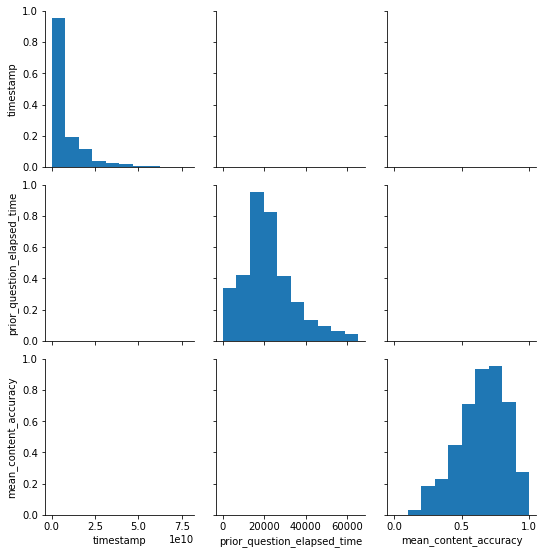

In [17]:
import seaborn as sns
plt.figure(figsize=(30, 18))
best_features = ['timestamp', 'prior_question_elapsed_time', 'mean_content_accuracy']
X_best = new_train_df[best_features]
sns.pairplot(X_best)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
class model_selection(): 
    def __init__(self): 
        self.y_pred_FVC = pd.DataFrame()
        self.best_param = None
        self.scoring_train = 0
    
    
    def RandomForest(self, X, y, X_val, y_val): 
        params_rf = {'n_estimators': [50, 100], 'criterion': ['gini']}
        clf = GridSearchCV(RandomForestClassifier(), 
                           param_grid=params_rf, scoring='roc_auc')
        clf.fit(X, y)
        self.best_param = clf.best_params_
        self.scoring_train = clf.score(X, y)
        y_pred_rf_FVC = clf.predict_proba(X_val)

        self.y_pred_FVC = pd.concat([pd.Series(y_pred_rf_FVC[:, 1])], axis=1)
        return self.best_param, self.y_pred_FVC, self.scoring_train
    
    
    def XGBoost(self, X, y, X_val, y_val): 
        params_xgb = {'max_depth':[3, 4, 5, 6], 'eta' : [0.1, 0.2, 0.3]}
        clf = GridSearchCV(XGBClassifier(), 
                           param_grid=params_xgb, scoring='roc_auc')
        clf.fit(X, y)
        self.best_param = clf.best_params_
        self.scoring_train = clf.score(X, y)
        y_pred_xgb_FVC = clf.predict_proba(X_val)

        self.y_pred_FVC = pd.concat([pd.Series(y_pred_xgb_FVC[:, 1])], axis=1)
        return self.best_param, self.y_pred_FVC, self.scoring_train
    

    def LightGBM(self, X, y, X_val, y_val): 
        params_lgb = {'n_estimators':[100, 200], 'num_iterations': [100, 200, 300],
                      'learning_rate':[0.05, 0.1, 0.15, 0.20, 0.25, 0.3], 'boosting_type' :['goss', 'gbdt']}
        clf = GridSearchCV(LGBMClassifier(), 
                           param_grid=params_lgb, scoring='roc_auc')
        clf.fit(X, y)
        self.best_param = clf.best_params_
        self.scoring_train = clf.score(X, y)
        y_pred_lgb_FVC = clf.predict_proba(X_val)
        
        self.y_pred_FVC = pd.concat([pd.Series(y_pred_lgb_FVC[:, 1])], axis=1)
        return self.best_param, self.y_pred_FVC, self.scoring_train

In [ ]:
model_sel = model_selection()
rf = model_sel.RandomForest(X_train, y_train, X_val, y_val)
rf

In [ ]:
model_sel = model_selection()
xgb = model_sel.XGBoost(X_train, y_train, X_val, y_val)
xgb

In [ ]:
model_sel = model_selection()
lgbm = model_sel.LightGBM(X_train, y_train, X_val, y_val)
lgbm

In [ ]:
params_lgbm = {'n_estimators':[100, 200], 'num_iterations': [100, 200, 300],
                      'learning_rate':[0.05, 0.1, 0.15, 0.20, 0.25, 0.3], 'boosting_type' : ['goss', 'gbdt']}
lgbm_clf = GridSearchCV(LGBMClassifier(), param_grid=params_lgbm, scoring='roc_auc')
lgbm_clf.fit(X, y)

In [ ]:
lgbm_best_clf = lgbm_clf.best_estimator_
lgbm_feature_importances = lgbm_best_clf.feature_importances_
lgbm_feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importances':lgbm_feature_importances})
lgbm_feature_importances_df.sort_values('feature_importances',ascending=False)

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.set(font_scale=3)
sns.barplot(x="feature_importances", y="features", data=lgbm_feature_importances_df.sort_values(by="feature_importances", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
params_xgb = {'max_depth':[3, 4, 5, 6], 'eta' : [0.1, 0.2, 0.3]}
xgb_clf = GridSearchCV(XGBClassifier(), param_grid=params_xgb, scoring='roc_auc')
xgb_clf.fit(X, y)
xgb_best_clf = xgb_clf.best_estimator_
xbg_feature_importances = xgb_best_clf.feature_importances_
xbg_feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importances':xbg_feature_importances})
xbg_feature_importances_df.sort_values('feature_importances',ascending=False)

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=3)
sns.barplot(x="feature_importances", y="features", data=xbg_feature_importances_df.sort_values(by="feature_importances", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()

In [ ]:
params_rf = {'n_estimators': [50, 100], 'criterion': ['gini']}
rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=params_rf, scoring='roc_auc')
rf_clf.fit(X, y)


In [ ]:
rf_best_clf = rf_clf.best_estimator_
rf_feature_importances = rf_best_clf.feature_importances_
rf_feature_importances_df = pd.DataFrame({'features':list(X),
                                       'feature_importances':rf_feature_importances})
rf_feature_importances_df.sort_values('feature_importances',ascending=False)

In [ ]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=3)
sns.barplot(x="feature_importances", y="features", data=rf_feature_importances_df.sort_values(by="feature_importances", ascending=False))
plt.title('RandomForest Features')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

roc_rf = roc_auc_score(y_val, rf_best_clf.predict_proba(X_val)[:, 1])
roc_rf

In [ ]:
roc_xgb = roc_auc_score(y_val, xgb_best_clf.predict_proba(X_val)[:, 1])
roc_xgb

In [ ]:
roc_lgbm = roc_auc_score(y_val, lgbm_best_clf.predict_proba(X_val)[:, 1])
roc_lgbm

In [ ]:
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(y_val, lgbm_best_clf.predict_proba(X_val)[:, 1])
lgbm_roc_auc= auc(lgbm_fpr, l gbm_tpr)

sns.set(font_scale=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
        label='ROC curve (area = %0.4f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LigthGBM ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_val, xgb_best_clf.predict_proba(X_val)[:, 1])
xgb_roc_auc= auc(xgb_fpr, xgb_tpr)
sns.set(font_scale=1)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
        label='ROC curve (area = %0.4f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=(30, 17))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf_best_clf.predict_proba(X_val)[:, 1])
rf_roc_auc= auc(rf_fpr, rf_tpr)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_val, xgb_best_clf.predict_proba(X_val)[:, 1])
xgb_roc_auc= auc(xgb_fpr, xgb_tpr)
lgbm_fpr, lgbm_tpr, lgbm_thresholds = roc_curve(y_val, lgbm_best_clf.predict_proba(X_val)[:, 1])
lgbm_roc_auc= auc(lgbm_fpr, lgbm_tpr)
sns.set(font_scale=1)
plt.figure()
plt.plot(rf_fpr, rf_tpr, color='darkorange',
        label='ROC curve RF(area = %0.4f)' % rf_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, color='green',
        label='ROC curve XGB(area = %0.4f)' % xgb_roc_auc)
plt.plot(lgbm_fpr, lgbm_tpr, color='red',
        label='ROC curve LGBM(area = %0.4f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Algorithm's ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure(figsize=(30, 17))
sns.set(font_scale=2)
g = sns.heatmap(X.corr(), annot = True, vmin = 0, vmax = 1, cmap='coolwarm', fmt='.2g')
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90)
plt.show()

In [ ]:
xgb_best_clf.predict_proba(X_val)